In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm

from scipy.spatial import distance_matrix
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
import torch

from data import DataGatherer
import params
from test import encode_data
from models import load_model

/srv/public/Thibaud/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/srv/public/Thibaud/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
param_dic = params.__get_dict__()
print(param_dic["data_spliting"])

{'augmentations': ['addSomeNoise'],
 'batch_size': 32,
 'class_hidden_size': 256,
 'class_layers_nb': 1,
 'conv_features1_nb': 80,
 'conv_features2_nb': 30,
 'conv_kernel1_size': 15,
 'conv_kernel2_size': 5,
 'conv_layers_nb': 4,
 'data_limit': -1,
 'data_spliting': 'pos_split',
 'data_test_rate': 0.01,
 'data_type': 'not_complex',
 'data_use_position': False,
 'datafile': '/srv/public/Thibaud/datasets/ultrasec/Messung_9/messung9.2_data.npy',
 'device': 'cuda',
 'dropout_value': 0,
 'expender_hidden_size': 256,
 'expender_layers_nb': 1,
 'expender_out': 32,
 'feature_norm': 'layer',
 'flat_data': False,
 'labelfile': '/srv/public/Thibaud/datasets/ultrasec/Messung_9/messung9.2_labels.npy',
 'lambda_cov': 4,
 'lambda_distance': 11,
 'lambda_std': 1.2,
 'lambda_triplet': 10,
 'latent_dimention': 32,
 'learning_rate': 0.001,
 'loss': 'vicreg',
 'lr_limit': 0.0001,
 'model_name': 'Transformer3',
 'nb_epochs': 10000,
 'noise_amount': 0.01,
 'num_dev': 9,
 'num_pos': 48,
 'optimizer': 'Adam',

In [4]:
data = np.load(params.datafile)
label = np.load(params.labelfile)

num_classes = max(label[:, 0])
num_positions = max(label[:, 1])
print(num_classes, num_positions)

8 49


In [5]:
dg = DataGatherer()
trainDataloader, valDataloader = dg.spliting_data()

In [20]:
model = torch.load("../data/model_noiseMore_2250.pth")

In [21]:
encoded_train, labels_train = encode_data(model, trainDataloader)
encoded_test, labels_test = encode_data(model, valDataloader)

# To do to try

- XGBoost classify the encoded values
- Code a little Re-Identification setup on the test+train data
    - Basic anchor + distance to anchor seting (no need to update)
- Vote on n sample of same device elements (does it improve from accuracy ?)
- Estimate the time to encode + computational needs
- Try isolated device from train to reid between all positions
- Try multiple unseen positions if they match one to another
- Do a study of capabilities according to the amount of data available and it's cleaness

In [22]:
# Plotting
def scatter_plot(X, Y):
        dimentions = [[2*i, i*2+1] for i in range(1)]
        colors_base = cm.rainbow(np.linspace(0, 1, num_classes+1))
        plt.rcParams["figure.figsize"] = (5,5)
        cmap, norm = matplotlib.colors.from_levels_and_colors(np.arange(0, num_classes+2)- 0.5, colors_base)

        for i in range(len(dimentions)):
                fig, ax = plt.subplots()
                scatter = ax.scatter(X[:, dimentions[i][0]], X[:, dimentions[i][1]], c=Y, norm=norm, cmap=cmap, marker=".", linewidths=0.5, s=25)
                handles, lab = scatter.legend_elements(prop="colors", num=num_classes+1, alpha=0.6)
                legend1 = ax.legend(handles, lab,
                        loc="lower left", title="Device id")
                ax.add_artist(legend1)
                ax.set_title("dimentions " + str(i*2) + "and " + str(i*2+1))
                # .legend(loc='upper left',prop = {'size':7},bbox_to_anchor=(1,1))
                # plt.tight_layout(pad=5)
                plot_img = "data/plot_"+str(i)+".png"
        return fig

8


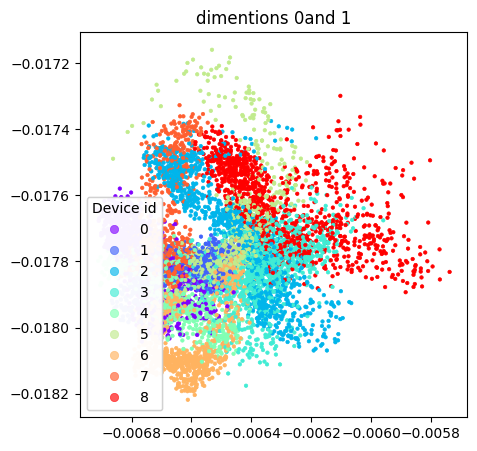

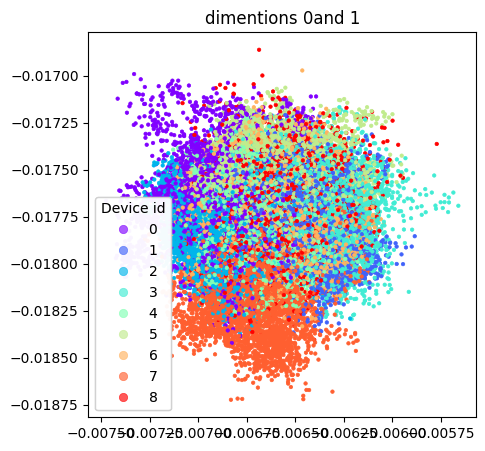

In [23]:
print(max(labels_test))
scatter_plot(np.array(encoded_test), np.array(labels_test))
plt.show()

r = np.random.choice(len(encoded_train), size=len(encoded_train)//10, replace=False)

scatter_plot(np.array(encoded_train)[r], np.array(labels_train)[r])
plt.show()

In [24]:
# For each class, gather the centroid from train data as an anchor
centroids = []

for dev in range(num_classes+1):
    ids_dev = np.where(np.array(labels_train) == dev)
    class_encoded = np.array(encoded_train)[ids_dev]
    centroids.append(class_encoded.mean(axis=0))

centroids = np.array(centroids)
print(centroids.shape)


(9, 450)


(9465, 9)
[0.00633233 0.00651268 0.00737187 0.00604989 0.00589814 0.00650411
 0.00659738 0.00662201 0.005287  ]


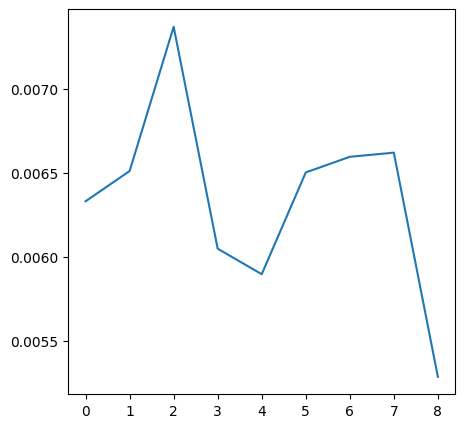

In [25]:
distances_centers = distance_matrix(encoded_test, centroids)
print(distances_centers.shape)
avg_ditance2center = np.mean(distances_centers, axis=0)
print(avg_ditance2center)
plt.plot(avg_ditance2center)
plt.show()

In [26]:
predicted_class = np.argmin(distances_centers, axis=1)
print(max(predicted_class))
print(max(labels_test))
print(predicted_class.shape)

8
8
(9465,)


confusion matrix
[[  88    0    0    7    2    0    0   30  918]
 [ 463  501    0    0  109    0    0    2    0]
 [   0 1090    0    2    0    0    0    0    0]
 [   0    6   58  931    0    0    0   12   11]
 [   0    0    0    0 1081    0    0    0    0]
 [   0    0    0    0    0   58  899    0   44]
 [   0    0    0    0    0    0  788    0  237]
 [  15    0    0  148  527    0    0   49  320]
 [   0   55    0    8  125    0  168    0  713]]


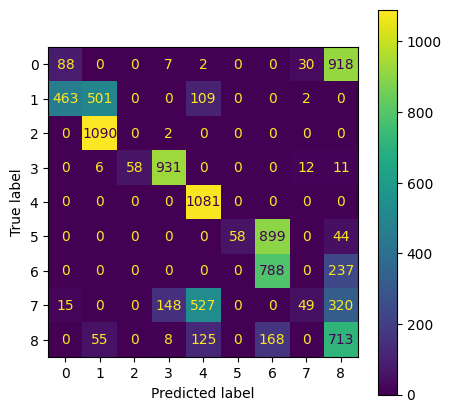

classification_report
              precision    recall  f1-score   support

           0       0.16      0.08      0.11      1045
           1       0.30      0.47      0.37      1075
           2       0.00      0.00      0.00      1092
           3       0.85      0.91      0.88      1018
           4       0.59      1.00      0.74      1081
           5       1.00      0.06      0.11      1001
           6       0.42      0.77      0.55      1025
           7       0.53      0.05      0.09      1059
           8       0.32      0.67      0.43      1069

    accuracy                           0.44      9465
   macro avg       0.46      0.44      0.36      9465
weighted avg       0.46      0.44      0.36      9465

predicted clusters


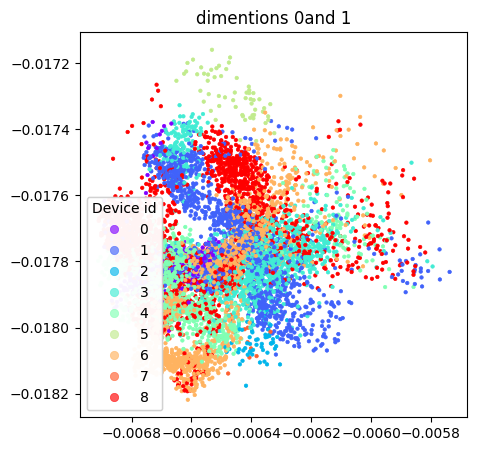

Ground truth labels


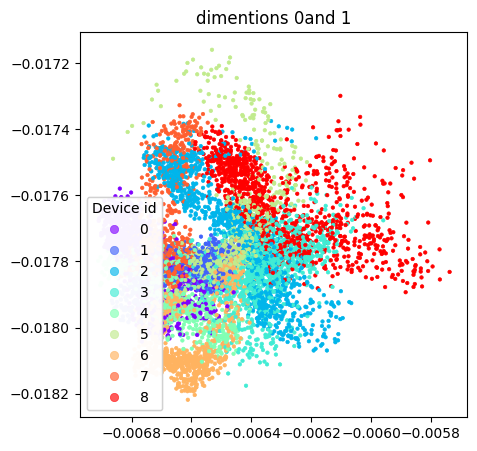

In [27]:
print('confusion matrix')
conf_mx =confusion_matrix(labels_test, predicted_class)
print(conf_mx)

# Confusion Matrix Display
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx,
                              display_labels=range(num_classes+1))
disp.plot()
plt.show()


print('classification_report')
print(classification_report(labels_test, predicted_class))


print("predicted clusters")
scatter_plot(np.array(encoded_test), np.array(predicted_class))
plt.show()

print("Ground truth labels")
scatter_plot(np.array(encoded_test), np.array(labels_test))
plt.show()

In [28]:
def plotting_2d_data(encoded_data, dev_labels, dimentions=[0, 1]):
    X = np.array(encoded_data)
    plt.rcParams["figure.figsize"] = (10,10)
    plt.scatter(X[:, dimentions[0]], X[:, dimentions[1]], c=dev_labels, marker=".", linewidths=0.5, s=20)
    plt.show()

# Check miss classification in 2D
T_SNE_test = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=10).fit_transform(np.array(encoded_test))

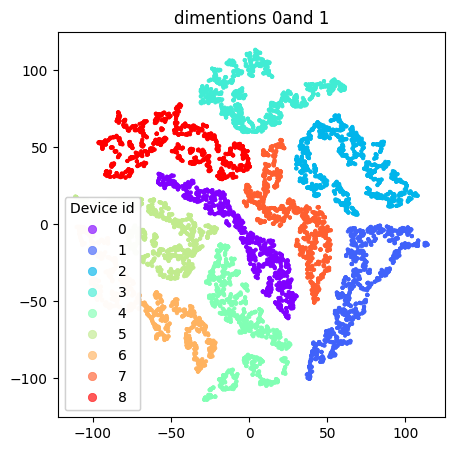

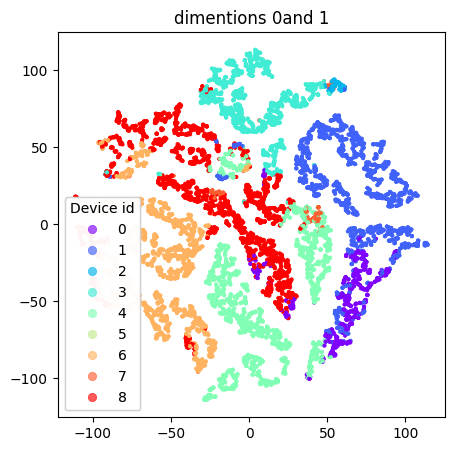

In [29]:
scatter_plot(T_SNE_test, labels_test)
scatter_plot(T_SNE_test, predicted_class)
plt.show()


# Use other types of classification

In [30]:
import xgboost as xgb 

In [31]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42) #"multi:softprob" #'binary:logistic' multi:softmax

xgb_model.fit(encoded_train, labels_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

confusion matrix
[[ 341    0    0    8    8   82   37  154  415]
 [  43   12    0    0  123    0    0   43  854]
 [   0 1084    0    2    2    0    0    0    4]
 [   0    0    1  747    0    0    0    0  270]
 [   0    0  399    0  526    0    0   60   96]
 [   0    0    0    0    0   95  360    0  546]
 [   0    0    0   19    0    0  440    0  566]
 [   1    0    0  367   95    0    0    0  596]
 [   0   16    0    0   44    0   16    0  993]]


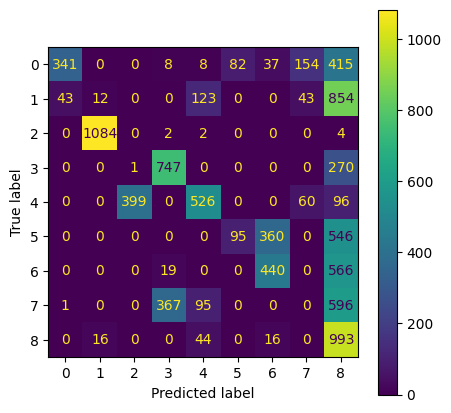

classification_report
              precision    recall  f1-score   support

           0       0.89      0.33      0.48      1045
           1       0.01      0.01      0.01      1075
           2       0.00      0.00      0.00      1092
           3       0.65      0.73      0.69      1018
           4       0.66      0.49      0.56      1081
           5       0.54      0.09      0.16      1001
           6       0.52      0.43      0.47      1025
           7       0.00      0.00      0.00      1059
           8       0.23      0.93      0.37      1069

    accuracy                           0.33      9465
   macro avg       0.39      0.33      0.30      9465
weighted avg       0.38      0.33      0.30      9465



In [32]:
predicted_class = xgb_model.predict(encoded_test)

print('confusion matrix')
conf_mx =confusion_matrix(labels_test, predicted_class)
print(conf_mx)

# Confusion Matrix Display
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx,
                              display_labels=range(num_classes+1))
disp.plot()
plt.show()


print('classification_report')
print(classification_report(labels_test, predicted_class))

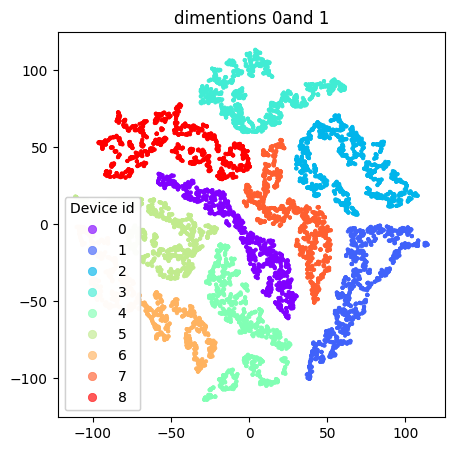

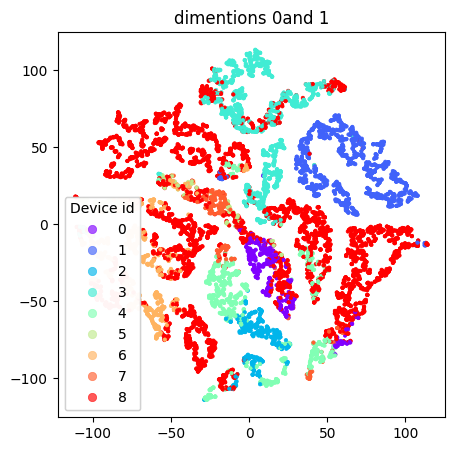

In [33]:
scatter_plot(T_SNE_test, labels_test)
scatter_plot(T_SNE_test, predicted_class)
plt.show()
